In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import qiime2 as q2

from biom import load_table, Table
from gemelli.joint_ctf import joint_ctf
from gemelli.ctf import ctf
from gemelli.preprocessing import clr_transformation
from tqdm.notebook import tqdm
from scipy.linalg import khatri_rao
from scipy.spatial import distance

%matplotlib inline
# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def sub_feat_trajectory(table,
                        #individual_loadings,
                        feature_loadings, 
                        #temporal_loadings,
                        component, modality, zoom=True, 
                        quantile=0.95, pseudocount=0):
    # get the loadings
    #sloadings = individual_loadings[modality][component]
    floadings = feature_loadings[modality][component]
    #tloadings = temporal_loadings[modality][component]
    table_df = table.to_dataframe()

    if zoom:
        #get top and bottom loading quantiles
        top_q = floadings.quantile(quantile)
        bottom_q = floadings.quantile(1-quantile)
        top_fts = floadings[floadings >= top_q].index
        bottom_fts = floadings[floadings <= bottom_q].index
        
        num = table_df.loc[top_fts].sum(axis=0)
        num += pseudocount
        denom = table_df.loc[bottom_fts].sum(axis=0)
        denom += pseudocount

        beta_l = np.log(num).values - np.log(denom).values
        beta_l = pd.DataFrame(beta_l, index=num.index, 
                              columns=[component])
    else:
        #calculate trajectories
        pass
        # y = []
        # for i, (individual_id, m) in enumerate(table.items()):
        #     y.append(np.concatenate(m.T.values))
        #     phi_ = phi_hat[ti[i]]
        #     new_m = np.outer(b_hat, phi_.T)
        #     new_m = a_hat[i] * new_m
        #     table_mod[individual_id] -= (lambda_coeff * new_m)
        #     residual_mod.append(table_mod[individual_id]**2)
        # residual_mod = np.sum(np.concatenate(residual_mod, axis=1))
        # y = np.concatenate(y)

    #drop any NaNs
    beta_l.dropna(inplace=True)

    return beta_l, top_fts, bottom_fts

def temporal_trajectory(individual_loadings, 
                        feature_loadings,
                        temporal_loadings, 
                        state_column, modality, 
                        component = 'component_1',
                        f_subset=True, quantile=0.95):
    #get loadings
    sloadings = individual_loadings[modality][[component]].copy()
    floadings = feature_loadings[modality][[component]].copy()
    t_index = temporal_loadings[modality]['time_interval']
    tloadings = temporal_loadings[modality][[component]].copy()
    #add dummy column to all loadings
    sloadings['dummy'] = 1
    floadings['dummy'] = 1
    tloadings['dummy'] = 1

    #calculate the column-wise khatri-rao products
    #subject trajectory
    s_traj = khatri_rao(sloadings, tloadings)
    s_traj = pd.DataFrame(s_traj, columns=[component,'dummy'])
    #add subject IDs and resolution
    a_indexes_repeated = np.repeat(sloadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, sloadings.shape[0])
    s_traj['subjectID'] = a_indexes_repeated
    s_traj[state_column] = c_indexes_tiled
    
    #feature trajectory
    if f_subset:
        #get top and bottom loading quantiles
        top_q = floadings[component].quantile(quantile)
        bottom_q = floadings[component].quantile(1-quantile)
        top_fts = floadings[floadings[component] >= top_q].index.tolist()
        bottom_fts = floadings[floadings[component] <= bottom_q].index.tolist()
        floadings = floadings.loc[top_fts+bottom_fts]
        f_traj = khatri_rao(floadings, tloadings)
    else:
        f_traj = khatri_rao(floadings, tloadings)
    
    f_traj = pd.DataFrame(f_traj, columns=[component,'dummy'])
    #add feature IDs and resolution
    b_indexes_repeated = np.repeat(floadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, floadings.shape[0])
    f_traj['featureID'] = b_indexes_repeated
    f_traj[state_column] = c_indexes_tiled
    #if top/bottom features used, label them accordingly
    if f_subset:
        f_traj['quantile'] = ['top_q' if x in top_fts else 'bottom_q' for x in f_traj.featureID]

    #remove dummy columns
    s_traj.drop(columns=['dummy'], inplace=True)
    f_traj.drop(columns=['dummy'], inplace=True)
    return s_traj, f_traj

def ctf_subject_trajectory(individual_loadings, 
                            temporal_loadings, 
                            modality='16S',
                            components=['component_1', 
                                        'component_2', 
                                        'component_3']):
    # get modality-specific loadings
    sub_loads = individual_loadings[modality]
    temp_loads = temporal_loadings[modality]
    
    # list of each condition-subject distance
    #subject_distances = []
    # list of components in subject trajectory
    subject_temp_trajectory = []
    # for each component in the rank given to TensorFactorization
    for component in components:
        # component condition-subject trajectory
        #dtmp = (sub_loads[component].values*condition[component].values)
        #reshape for dot product
        a = sub_loads[component].values.reshape(-1, 1)
        b = temp_loads[component].values.reshape(-1, 1)
        dtmp = np.dot(a, b.T).flatten()
        subject_temp_trajectory.append(dtmp)
    
    # combine all n_components
    subject_temp_trajectory = np.array(subject_temp_trajectory).T
    # double check check centered
    subject_temp_trajectory -= subject_temp_trajectory.mean(axis=0)
    #print(subject_temp_trajectory.shape)
    # save subject-condition trajectory and distance matrix
    #subject_distances.append(distance.cdist(subject_temp_trajectory,
    #                                        subject_temp_trajectory))
    
    subject_indexes_repeated = np.repeat(sub_loads.index, temp_loads.shape[0])
    time_indexes_tiled = np.tile(temp_loads.time_interval, sub_loads.shape[0])
    subject_trajectory_df = pd.DataFrame(subject_temp_trajectory,
                                         index=subject_indexes_repeated,
                                         columns=components)
    subject_trajectory_df['resolution'] = time_indexes_tiled
    return subject_trajectory_df

def plot_test_stats(data, x, hue, 
                    y='test statistic', y_label='test statistic', 
                    title='Test Results', figsize=(12, 4),
                    vline=False, vline_y=0.05):

    fig, axn = plt.subplots(1, 2, figsize=figsize, sharey=False)
    sns.barplot(x=hue, y='test statistic', data=data, 
                ci=68, ax=axn[0])
    axn[0].set_facecolor('white')
    axn[0].set_xlabel(hue)
    axn[0].set_ylabel(y_label)
    sns.pointplot(x=x, hue=hue, y=y, 
                  data=data, ci=68, ax=axn[1])
    axn[1].set_facecolor('white')
    axn[1].set_ylabel(y_label)

    if vline:
        #plot horizontal line
        axn[1].axhline(y=vline_y, color='k', ls='--', lw=1)

    plt.suptitle(title, fontsize=18)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [3]:
# load filtered tables
body_site = 'Baby-Feces'
baby_gut_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
#baby_gut_mf = baby_gut_mf[baby_gut_mf.birth_mode_ms != 'CSseed']

body_site = 'Baby-Forearm'
baby_skin_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
#baby_skin_mf = baby_skin_mf[baby_skin_mf.birth_mode_ms != 'CSseed']

body_site = 'Baby-Mouth'
baby_mouth_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
#baby_mouth_mf = baby_mouth_mf[baby_mouth_mf.birth_mode_ms != 'CSseed']

In [ ]:
baby_gut_mf

,seqcount,orig_sampleid,study_id,primer_plate,well,lane,run,hospital_name,village,state,...,mother_abx_3rd_trimester_name,mother_race,current_breast_feeding,current_formula,current_solids,exclusive_breastfeed,birth_mode_ms,manuscript_use,life_stage,host_subject_id
sample_name,,,,,,,,,,,,,,,,,,,,,
10894.CH3141,51365.0,CH3141,10894.0,7,B6,3,2,HOSPITAL_UC,Santiago,Santiago,...,NaN,Hispanic,Yes,No,Yes,No,Vag,Possible,26-51,CH.18B
10894.CH496,54595.0,CH496,10894.0,5,H3,3,2,HOSPITAL_UC,Santiago,Santiago,...,NaN,Hispanic,Yes,No,No,Yes,CS,Possible,17-26,CH.3B
10894.HR1790,108915.0,HR1790,10894.0,8,G7,1,1,HVHC,Peekskill,NY,...,NaN,Caucasian,Yes,No,No,Yes,Vag,Possible,0-2,HR.28
10894.CH870,87836.0,CH870,10894.0,5,B2,1,2,HOSPITAL_UC,Santiago,Santiago,...,NaN,NaN,No,Yes,Yes,No,CS,Possible,26-51,CH.5B
10249.C004.03SS,20236.0,C004.03SS,10249.0,NaN,NaN,NaN,ECAM.seq1,NaN,New York,New York,...,Ampicillin,NaN,NaN,NaN,NaN,eb,CS,Possible,4-17,ECAM.4.B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10249.C045.06SS,33402.0,C045.06SS,10249.0,NaN,NaN,NaN,ECAM.seq4,NaN,New York,New York,...,NaN,NaN,NaN,NaN,NaN,eb,Vag,Possible,17-26,ECAM.45.B
10894.12261.C.0206,25342.0,F19T0M2B,12261.0,P05_E6,NaN,NaN,MGDB_Run26,PUC,Stgo,RM,...,NaN,Hispanic,Yes,No,No,Yes,CSseed,Possible,0-2,Chile.renace_38
10894.NY1437,600.0,NY1437,10894.0,2,E4,1,1,Lenox_Hill,NYC,NY,...,NaN,Caucasian,Yes,Yes,No,No,Vag,Possible,0-2,NY.14


In [8]:
display(baby_gut_mf.iloc[0:5, 0:12])
display(baby_gut_mf.iloc[0:5, 12:24])
display(baby_gut_mf.iloc[0:5, 24:36])
display(baby_gut_mf.iloc[0:5, 36:])

,seqcount,orig_sampleid,study_id,primer_plate,well,lane,run,hospital_name,village,state,country,irb_institution
sample_name,,,,,,,,,,,,
10894.CH3141,51365.0,CH3141,10894.0,7,B6,3,2,HOSPITAL_UC,Santiago,Santiago,Chile,NYU
10894.CH496,54595.0,CH496,10894.0,5,H3,3,2,HOSPITAL_UC,Santiago,Santiago,Chile,NYU
10894.HR1790,108915.0,HR1790,10894.0,8,G7,1,1,HVHC,Peekskill,NY,USA,NYU
10894.CH870,87836.0,CH870,10894.0,5,B2,1,2,HOSPITAL_UC,Santiago,Santiago,Chile,NYU
10249.C004.03SS,20236.0,C004.03SS,10249.0,NaN,NaN,NaN,ECAM.seq1,NaN,New York,New York,USA,NYU


,project_name,body_site_orig,body_site_type,familyid,familyid_unique,mom_baby,subjectid,subjectid_unique,date_sampling,real_sampling_time,date_sampling_category,date_sampling_category_days
sample_name,,,,,,,,,,,,
10894.CH3141,Chile,Feces,Fecal,18,CH.18,Baby,18B,CH.18B,5/19/15,300,Month_10,Day_300
10894.CH496,Chile,Feces,Fecal,3,CH.3,Baby,3B,CH.3B,4/22/15,152,Month_5,Day_150
10894.HR1790,DevelopmentEcologyoftheHumanMicrobiome_Longitu...,Feces,Fecal,14,HR.14,Baby,28,HR.28,10/1/15,2,Day_2-3,Day_2-3
10894.CH870,DevelopmentEcologyoftheHumanMicrobiome_Longitu...,Feces,Fecal,5,CH.5,Baby,5B,CH.5B,3/22/15,346,Month_11,Day_330
10249.C004.03SS,ECAM,Stool_Stabilizer,Fecal,4,ECAM.4,Baby,4,ECAM.4.B,6/28/12,55,Month_2,Day_60


,date_sampling_category_days_continuous,baby_sex,birth_mode,seeding_method,baby_birth_date,current_abx,mother_prenatal_gbs,mother_abx_perinatal,mother_abx_perinatal_name,mother_abx_1st_trimester,mother_abx_1st_trimester_name,mother_abx_2nd_trimester
sample_name,,,,,,,,,,,,
10894.CH3141,300.0,M,Vag,NaN,7/23/14,No,No,No,No,No,NaN,No
10894.CH496,150.0,M,CS,NaN,11/21/14,No,No,Yes,CEFAZOLIN,No,NaN,No
10894.HR1790,2.0,F,Vag,NaN,9/29/15,No,No,No,No,NaN,NaN,NaN
10894.CH870,330.0,F,CS,NaN,4/10/14,NaN,No,Yes,No,Yes,NaN,No
10249.C004.03SS,60.0,M,CS,NaN,5/4/12,No,No,Yes,Clindamycin,No,NaN,No


,mother_abx_2nd_trimester_name,mother_abx_3rd_trimester,mother_abx_3rd_trimester_name,mother_race,current_breast_feeding,current_formula,current_solids,exclusive_breastfeed,birth_mode_ms,manuscript_use,life_stage,host_subject_id
sample_name,,,,,,,,,,,,
10894.CH3141,NaN,No,NaN,Hispanic,Yes,No,Yes,No,Vag,Possible,26-51,CH.18B
10894.CH496,NaN,No,NaN,Hispanic,Yes,No,No,Yes,CS,Possible,17-26,CH.3B
10894.HR1790,NaN,NaN,NaN,Caucasian,Yes,No,No,Yes,Vag,Possible,0-2,HR.28
10894.CH870,NaN,No,NaN,NaN,No,Yes,Yes,No,CS,Possible,26-51,CH.5B
10249.C004.03SS,NaN,Yes,Ampicillin,NaN,NaN,NaN,NaN,eb,CS,Possible,4-17,ECAM.4.B


In [ ]:
#hospital_name, village, state, country, body_site_orig, familyid, baby_sex, birth_mode, birth_mode_ms, mother_race

Index(['seqcount', 'orig_sampleid', 'study_id', 'primer_plate', 'well', 'lane',
       'run', 'hospital_name', 'village', 'state', 'country',
       'irb_institution', 'project_name', 'body_site_orig', 'body_site_type',
       'familyid', 'familyid_unique', 'mom_baby', 'subjectid',
       'subjectid_unique', 'date_sampling', 'real_sampling_time',
       'date_sampling_category', 'date_sampling_category_days',
       'date_sampling_category_days_continuous', 'baby_sex', 'birth_mode',
       'seeding_method', 'baby_birth_date', 'current_abx',
       'mother_prenatal_gbs', 'mother_abx_perinatal',
       'mother_abx_perinatal_name', 'mother_abx_1st_trimester',
       'mother_abx_1st_trimester_name', 'mother_abx_2nd_trimester',
       'mother_abx_2nd_trimester_name', 'mother_abx_3rd_trimester',
       'mother_abx_3rd_trimester_name', 'mother_race',
       'current_breast_feeding', 'current_formula', 'current_solids',
       'exclusive_breastfeed', 'birth_mode_ms', 'manuscript_use', 'life_st

In [5]:
mf = baby_gut_mf.copy()
mf2 = baby_skin_mf.copy()

#pick the table to use
body_site = 'Baby-Feces' #Baby-Feces, Baby-Forearm, Baby-Mouth
body_site_title = 'Gut'
body_site_save = 'Gut-Skin'
bt = load_table('../data/%s/table-filtered.biom' % body_site)

In [6]:
# define temporary output directory
output_dir = '/Users/bec5786/Desktop/temp/joint_ctf_out/mod1/'
csseed = False
tps = 'all'     #Options: 'all', '7-360'
country = ['all'] #Options: 'all', 'USA', 'Chile', 'Spain'

if csseed:
    output_dir = '{}CSseed_true/'.format(output_dir)
else:
    output_dir = '{}CSseed_false/'.format(output_dir)

In [7]:
#(optional) subsetting
#define time splits
state_column = 'date_sampling_category_days_continuous'
splits_ = {'all':[0.0, 1.0, 2.0, 7.0, 14.0, 
                  21.0, 30.0, 60.0, 90.0, 120.0, 
                  150.0, 180.0, 210.0, 240.0, 
                  270.0, 300.0, 330.0, 360.0],
           '0-2':[0.0, 1.0, 2.0],
           '7-360':[7.0, 14.0, 30.0,
                    60, 120, 180, 360]}

if csseed == False:
    mf = mf[mf.birth_mode_ms != 'CSseed']

#mf_120sub = mf[mf.date_sampling_category_days_continuous <= 120]
#mf_7_360 = mf[mf[state_column].isin(splits_['7-360'])]

In [8]:
#pick the metadata to be used (original or subset)
if tps == '7-360':
    mf = mf[mf[state_column].isin(splits_['7-360'])]

if country != ['all']:
    mf = mf[mf.country.isin(country)]

In [9]:
#find subjects that are shared across sites
shared_subjects = [s_id for s_id in mf.subjectid_unique.unique() if s_id in mf2.subjectid_unique.unique()]
mf_shared = mf[mf.subjectid_unique.isin(shared_subjects)]
print("# shared subjects: {}".format(len(shared_subjects)))

# shared subjects: 71


In [10]:
#define mf to use
mf_all = mf.copy()
mf = mf_shared #mf_true, mf_shared
#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep = mf[subject_id_column].value_counts()[mf[subject_id_column].value_counts() > 1].index
mf = mf[mf[subject_id_column].isin(ids_to_keep)]
#sanity check
print(len(mf[subject_id_column].unique()))

71


In [11]:
for country in mf.country.unique():
    print(country)
    mf_country = mf[mf.country==country]
    print("# samples:", mf_country.shape[0])
    #subset based on mode of delivery
    vag_samples = mf_country[mf_country.birth_mode_ms=='Vag']
    print('Vag unique subjects:', len(vag_samples.subjectid_unique.unique()))
    print('Vag samples:', vag_samples.shape[0])
    cs_samples = mf_country[mf_country.birth_mode_ms=='CS']
    print('CS unique subjects:', len(cs_samples.subjectid_unique.unique()))
    print('CS samples:', cs_samples.shape[0])
    print()

Chile
# samples: 180
Vag unique subjects: 8
Vag samples: 110
CS unique subjects: 5
CS samples: 70

USA
# samples: 297
Vag unique subjects: 42
Vag samples: 268
CS unique subjects: 4
CS samples: 29

Spain
# samples: 87
Vag unique subjects: 7
Vag samples: 51
CS unique subjects: 5
CS samples: 36



In [12]:
#run joint-ctf
bt_clr = clr_transformation(bt.copy(), pseudocount=0.5)
print(bt_clr.shape)

(subject_loads, feature_loads, 
 state_loads, subject_lambdas,
 var_explained, feature_covs) = joint_ctf(tables=[bt_clr],
                                          sample_metadatas=[mf],
                                          modality_ids=['16S'],
                                          individual_id_column='subjectid_unique',
                                          state_column='date_sampling_category_days_continuous')

print(subject_lambdas)
print(var_explained.T)

(3462, 1282)
Calculate components for component_1
Reached convergence in 21 iterations
Calculate components for component_2
Reached convergence in 10 iterations
Calculate components for component_3
Reached convergence in 13 iterations
     component_1  component_2  component_3
16S  1153.726601   423.278046   408.582917
               component_1  component_2  component_3
var_explained     0.632162     0.223468      0.14437


In [13]:
#save the results
# subject_loads['16S'].to_csv('{}loadings/{}_subject_loadings_{}.tsv'.format(output_dir, body_site_save, tps), sep='\t')
# feature_loads['16S'].to_csv('{}loadings/{}_feature_loadings_{}.tsv'.format(output_dir, body_site_save, tps), sep='\t')
# state_loads['16S'].to_csv('{}loadings/{}_temporal_loadings_{}.tsv'.format(output_dir, body_site_save, tps), sep='\t')
# subject_lambdas.to_csv('{}loadings/{}_lambdas_{}.tsv'.format(output_dir, body_site_save, tps), sep='\t')
# var_explained.T.to_csv('{}loadings/{}_var_explained_{}.tsv'.format(output_dir, body_site_save, tps), sep='\t')
# for component, pc in zip(['component_1', 'component_2', 'component_3'], ['PC1', 'PC2', 'PC3']):
#     feature_covs[component].to_csv('{}loadings/{}_feature_covs_{}_{}.tsv'.format(output_dir, body_site_save, pc, tps), sep='\t')

In [14]:
meta_cat = 'birth_mode_ms'
mf_map = mf.copy()
mf_map = mf_map.drop_duplicates(subset='subjectid_unique')
mf_map = mf_map.set_index('subjectid_unique')

mf_collapsed = mf.groupby('subjectid_unique').agg({meta_cat:'first'})
mf_collapsed['country'] = mf_collapsed.index.map(mf_map['country'])
mf_collapsed['baby_sex'] = mf_collapsed.index.map(mf_map['baby_sex'])

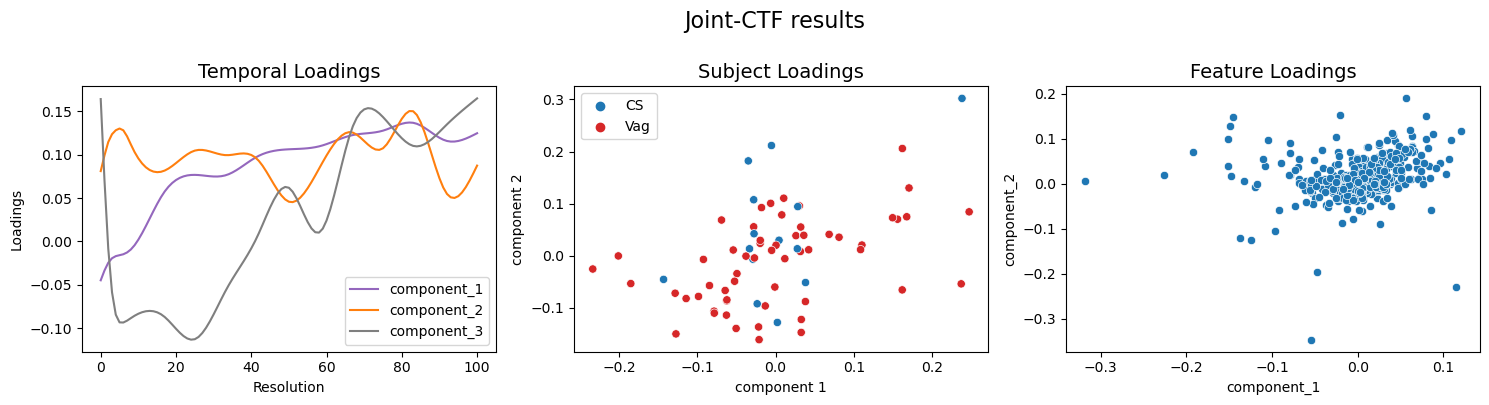

In [15]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
group_colors = {'Vag': 'tab:red', 
                'CS': 'tab:blue',
                'CSseed': 'tab:green'}
pc_colors = {'component_1': 'tab:purple',
             'component_2': 'tab:orange',
             'component_3': 'tab:grey'}

# Plotting temporal loadings
fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
sns.lineplot(data=state_loads['16S'][['component_1', 'component_2', 'component_3']], 
             ax=axn[0], dashes=False, palette=pc_colors)
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[0].set_xlabel('Resolution')
axn[0].set_ylabel('Loadings')

# Plotting individual loadings
sns.scatterplot(x=subject_loads['16S'][comp1], y=subject_loads['16S'][comp2],  
                ax=axn[1], hue=mf_collapsed[meta_cat], palette=group_colors)
axn[1].set_title('Subject Loadings', fontsize=14)
axn[1].legend(loc='best')

# Plotting feature loadings
sns.scatterplot(x=feature_loads['16S'][comp1], y=feature_loads['16S'][comp2], 
                ax=axn[2])
axn[2].set_title('Feature Loadings', fontsize=14)

# Adjusting titles and labels
plt.suptitle('Joint-CTF results', fontsize=16, x=0.52, y=1)
for ax in axn[1:2]:
    ax.set_xlabel(comp1.replace('_', ' '))
    ax.set_ylabel(comp2.replace('_', ' '))

plt.tight_layout()
#save the plot
#plt.savefig('{}png/{}_loadings_{}.png'.format(output_dir, body_site_save, tps), dpi=300)
plt.show()

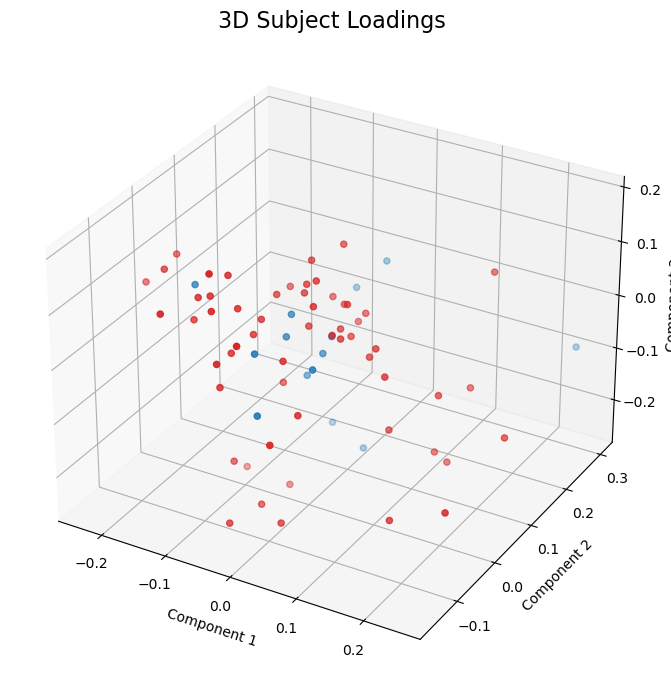

In [16]:
#plot individual loadings from joint-ctf
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(subject_loads['16S']['component_1'], 
             subject_loads['16S']['component_2'], 
             subject_loads['16S']['component_3'],
             c=mf_collapsed[meta_cat].map(group_colors))
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('3D Subject Loadings', fontsize=16)
plt.tight_layout()
#plt.savefig('{}png/{}_loadings_3D_{}.png'.format(output_dir, body_site_save, tps), dpi=300)
plt.show()

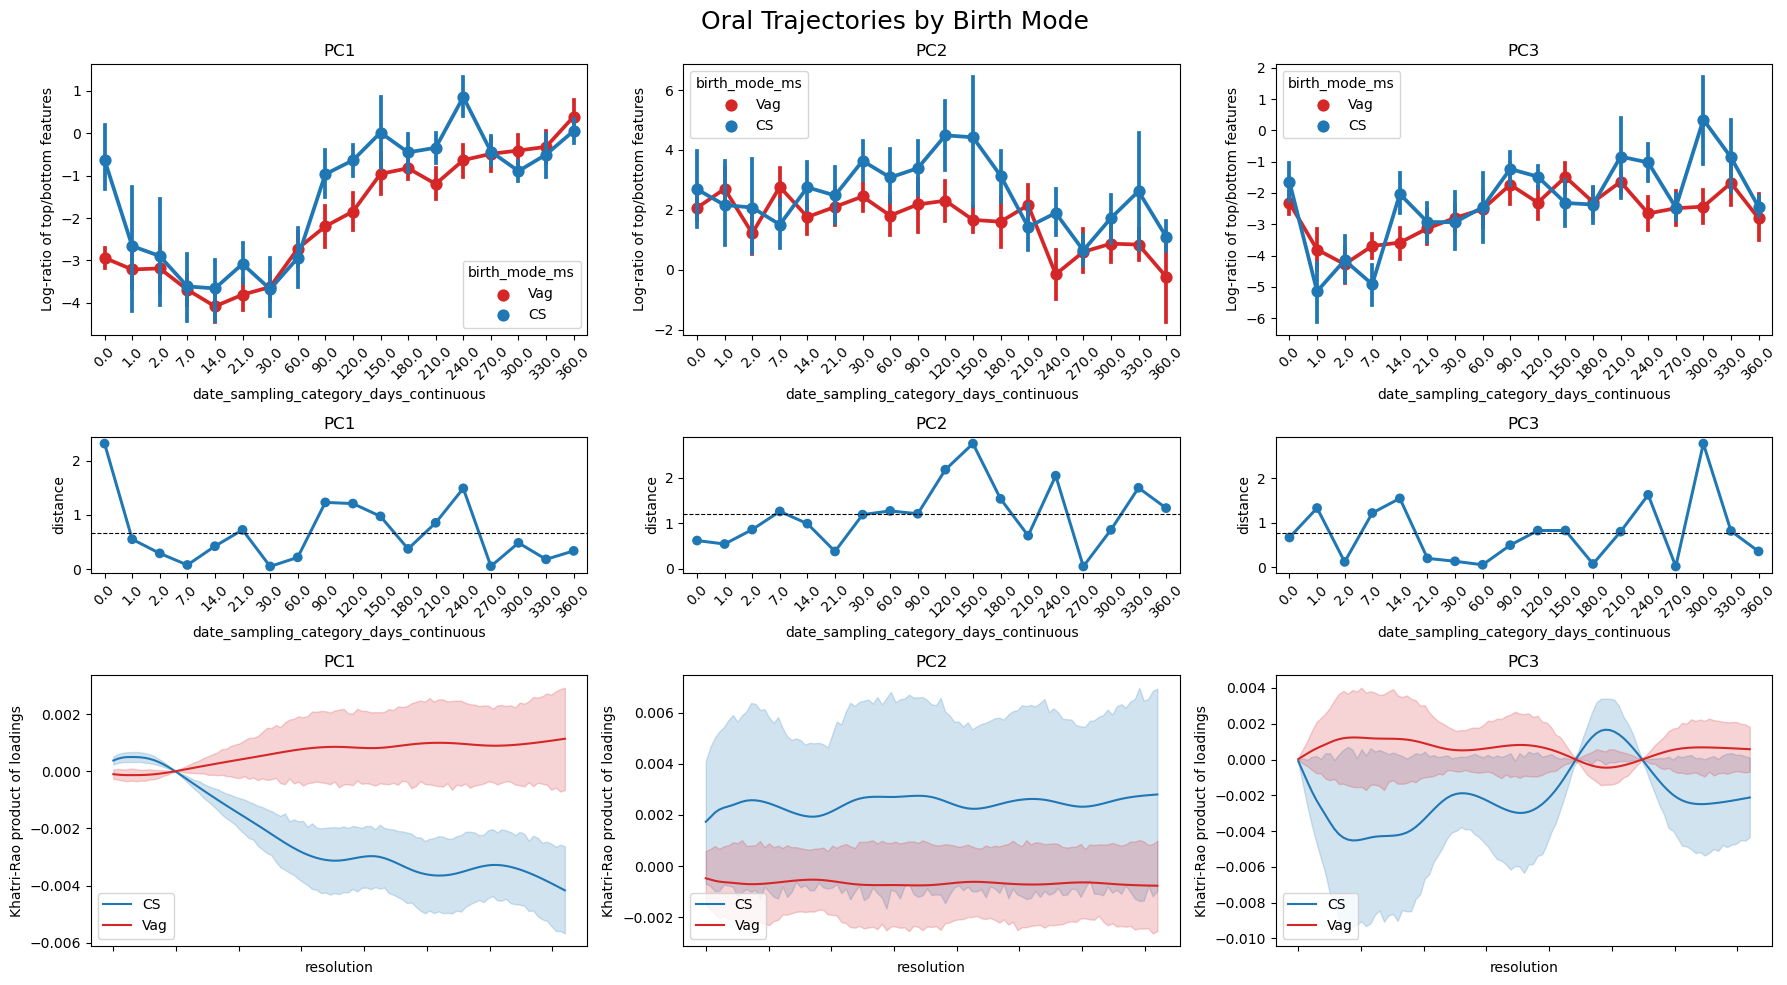

In [54]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'
quantile=0.95

fig, axn = plt.subplots(3, 3, figsize=(18, 10), gridspec_kw = {'height_ratios':[6,3,6]})

for i, component in enumerate(components):
    beta_l, top_fts, bottom_fts = sub_feat_trajectory(bt, feature_loads, component=component,
                                                      modality='16S', pseudocount=0.5, quantile=quantile)
    
    #save top and bottom features
    q_text = int(100*(1 - quantile))
    pd.DataFrame(top_fts, columns=['featureID']).to_csv('{}log_ratio_features/{}_top{}_features_PC{}_{}.txt'.format(output_dir, body_site_save, q_text, i+1, tps), 
                                                        sep='\t', index=False)
    pd.DataFrame(bottom_fts, columns=['featureID']).to_csv('{}log_ratio_features/{}_bottom{}_features_PC{}_{}.txt'.format(output_dir, body_site_save, q_text, i+1, tps), 
                                                        sep='\t', index=False)
    
    #map columns of interest from mf
    beta_l[state_column] = beta_l.index.map(mf[state_column])
    beta_l['subjectID'] = beta_l.index.map(mf['subjectid_unique'])
    beta_l[cat_of_interest] = beta_l.index.map(mf[cat_of_interest])
    beta_l.dropna(inplace=True)

    #find timepoints at which trajectories seem to converge
    cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
    beta_l_dist = beta_l.groupby([state_column, 
                                    cat_of_interest]).mean()
    beta_l_dist = beta_l_dist.unstack()
    beta_l_dist.columns = beta_l_dist.columns.droplevel()
    beta_l_dist.reset_index(inplace=True)
    beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                      beta_l_dist[cat2]) ** 2)

    #calculate trajectories based on khatri-rao product
    strajectory_gut, ftrajectory_gut = temporal_trajectory(subject_loads, feature_loads,
                                                            state_loads, modality='16S',
                                                            state_column='resolution',
                                                            component=component,
                                                            f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory_gut[cat_of_interest] = strajectory_gut['subjectID'].map(mf_collapsed[cat_of_interest])
    strajectory_gut['country'] = strajectory_gut['subjectID'].map(mf_collapsed['country'])

    ##plotting
    #plot trajectory #1
    sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                  data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
    axn[0,i].set_title('PC{}'.format(i+1))
    xlabels = axn[0,i].get_xticklabels()
    axn[0,i].set_xticklabels(xlabels, rotation=45)
    axn[0,i].set_ylabel('Log-ratio of top/bottom features')
    #plot distance between points in trajectory #1
    sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
                ax=axn[1,i], errorbar=None, scale=0.8)
    axn[1,i].set_title('PC{}'.format(i+1))
    axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
    axn[1,i].set_xticklabels(xlabels, rotation=45)
    #plot trajectory #2
    sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
                data=strajectory_gut, ax=axn[2,i], ci=68, palette=group_colors)
    axn[2,i].set_title('PC{}'.format(i+1))
    axn[2,i].legend(loc='lower left')
    axn[2,i].set_xticklabels([], rotation=45)
    axn[2,i].set_ylabel('Khatri-Rao product of loadings')

plt.suptitle('{} Trajectories by Birth Mode'.format(body_site_title), fontsize=18)
plt.tight_layout()
plt.savefig('{}png/{}_trajectories_{}.png'.format(output_dir, body_site_save,tps), dpi=300)
plt.show()

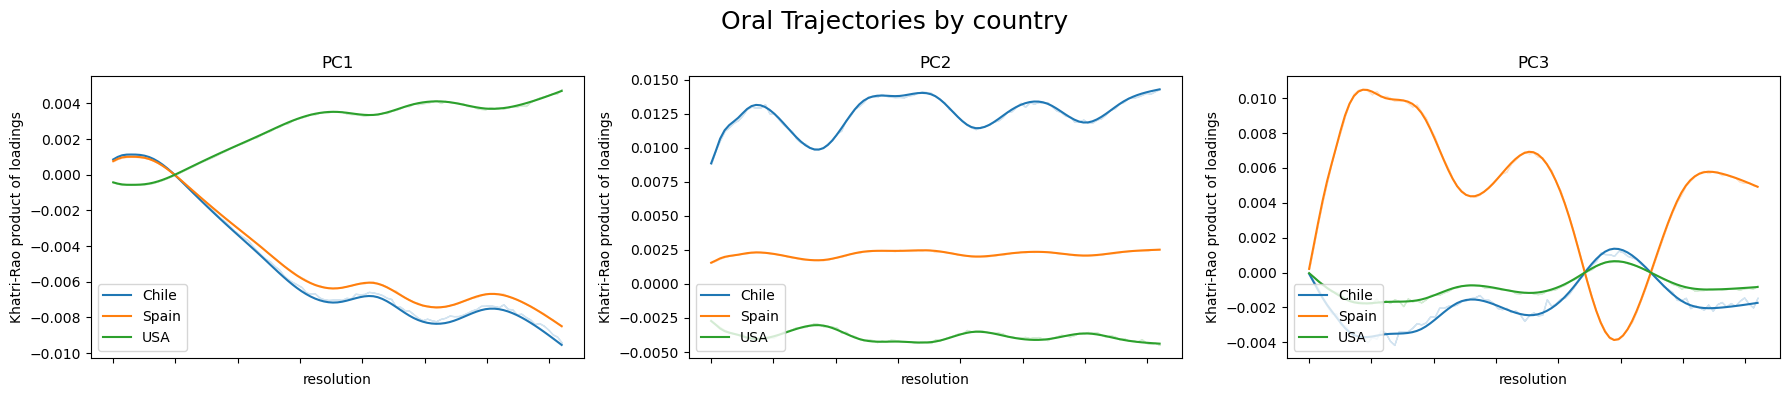

In [55]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'

fig, axn = plt.subplots(1, 3, figsize=(18, 4))

for i, component in enumerate(components):

    strajectory_gut, ftrajectory_gut = temporal_trajectory(subject_loads, feature_loads,
                                                            state_loads, modality='16S',
                                                            state_column='resolution',
                                                            component=component,
                                                            f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory_gut[cat_of_interest] = strajectory_gut['subjectID'].map(mf_collapsed[cat_of_interest])
    strajectory_gut['country'] = strajectory_gut['subjectID'].map(mf_collapsed['country'])
    strajectory_gut['baby_sex'] = strajectory_gut['subjectID'].map(mf_collapsed['baby_sex'])
    #plot trajectory #2xs
    sns.lineplot(x='resolution', y=component, hue='country', 
                 data=strajectory_gut, ax=axn[i], ci=0)
    axn[i].set_title('PC{}'.format(i+1))
    axn[i].legend(loc='lower left')
    axn[i].set_xticklabels([], rotation=45)
    axn[i].set_ylabel('Khatri-Rao product of loadings')

plt.suptitle('{} Trajectories by country'.format(body_site_title), fontsize=18)
plt.tight_layout()
plt.savefig('{}png/{}_trajectories_country_{}.png'.format(output_dir, body_site_save, tps), dpi=300)
plt.show()

In [56]:
# #calculate trajectories based on CTF code
# components = ['component_1', 'component_2', 'component_3']
# subject_id_column = 'subjectid_unique'
# state_column =  'date_sampling_category_days_continuous'
# cat_of_interest = 'birth_mode_ms'

# fig, axn = plt.subplots(1, 3, figsize=(18, 4))

# for i, component in enumerate(components):
    
#     strajectory_gut = ctf_subject_trajectory(subject_loads, state_loads, 
#                                              modality='16S',
#                                              components=['component_1', 
#                                                          'component_2', 
#                                                          'component_3'])

#     #map columns of interest from mf
#     strajectory_gut[cat_of_interest] = strajectory_gut.index.map(mf_collapsed[cat_of_interest])
#     #plot trajectory #2
#     sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
#                  data=strajectory_gut, ax=axn[i], ci=68)
#     axn[i].set_title('PC{}'.format(i+1))
#     axn[i].legend(loc='lower left')
#     axn[i].set_xticklabels([], rotation=45)
#     axn[i].set_ylabel('Khatri-Rao product of loadings')

# plt.suptitle('{} Trajectories by Birth Mode'.format(body_site), fontsize=18)
# plt.tight_layout()
# plt.show()

In [57]:
# to_keep = [7.00, 14.06, 31.71, 59.95, 
#            119.96, 179.97, 360.00]

# #calculate trajectories based on log-ratio abundance
# components = ['component_1', 'component_2', 'component_3']
# subject_id_column = 'subjectid_unique'
# state_column =  'date_sampling_category_days_continuous'
# cat_of_interest = 'birth_mode_ms'

# fig, axn = plt.subplots(1, 3, figsize=(18, 4))

# for i, component in enumerate(components):
    
#     state_loads['16S'] = state_loads['16S'][state_loads['16S'].time_interval.isin(to_keep)]
#     strajectory_gut = ctf_subject_trajectory(subject_loads, state_loads, 
#                                              modality='16S',
#                                              components=['component_1', 
#                                                          'component_2', 
#                                                          'component_3'])

#     #map columns of interest from mf
#     strajectory_gut[cat_of_interest] = strajectory_gut.index.map(mf_collapsed[cat_of_interest])
#     #plot trajectory #2
#     sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
#                  data=strajectory_gut, ax=axn[i], ci=68)
#     axn[i].set_title('PC{}'.format(i+1))
#     axn[i].legend(loc='lower left')
#     axn[i].set_xticklabels([], rotation=45)
#     axn[i].set_ylabel('Khatri-Rao product of loadings')

# plt.suptitle('{} Trajectories by Birth Mode'.format(body_site), fontsize=18)
# plt.tight_layout()
# plt.show()